# **Setup and Libraries**

In [1]:
import os, random, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import nltk
try:
    nltk.data.find('corpora/wordnet')
except Exception:
    nltk.download('wordnet')
    nltk.download('omw-1.4')
from nltk.corpus import wordnet

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Configuration**

In [2]:
RANDOM_SEED = 44
MODEL_NAME = "roberta-large"     
OUTPUT_DIR = "/kaggle/working/roberta_best" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

BATCH_SIZE = 4                   
MAX_LEN = 192
LR = 1e-5
EPOCHS = 8
PATIENCE = 2
CLIP_NORM = 1.0
UNFREEZE_LAST_N = 6              
ACCUM_STEPS = 2                  
USE_SWA = True                  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything()

Device: cuda


# **Load & Split Dataset**

In [3]:
with open("/kaggle/input/emotion-text/emotions_text.csv", "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

lines = [line.strip().strip('"') for line in lines if line.strip()]
lines = lines[1:]

data = []
for line in lines:
    parts = line.rsplit(",", 1)
    if len(parts) == 2:
        sentence, label = parts
        data.append((sentence, label.strip('"')))
    else:
        print(" Skipping malformed line:", line)

df = pd.DataFrame(data, columns=["sentence", "label"])

In [4]:

df.columns = ['sentence', 'label']
df.dropna(inplace=True)
df['label'] = df['label'].astype(str)


import re
def light_clean(s):
    s = str(s)
    s = re.sub(r'http\S+|www\S+|https\S+', '', s) 
    s = re.sub(r'\s+', ' ', s).strip()           
    return s
df['sentence'] = df['sentence'].apply(light_clean)


def synonym_replace(sentence, n_replacements=1):
    words = sentence.split()
    if len(words) < 3:
        return sentence
    candidates = []
    for i, w in enumerate(words):
        if len(w) < 3 or not w.isalpha():
            continue
        syns = wordnet.synsets(w)
        lemmas = set()
        for s in syns:
            for l in s.lemmas():
                lemmas.add(l.name().replace('_', ' '))
        lemmas.discard(w) 
        if lemmas:
            candidates.append((i, list(lemmas)))
    if not candidates:
        return sentence
    
    num = min(n_replacements, max(1, int(len(candidates)*0.3)))
    chosen = random.sample(candidates, num)
    
    for idx, lem_list in chosen:
        words[idx] = random.choice(lem_list)
    return " ".join(words)


AUG_PROB = 0.35
num_to_augment = int(len(df) * AUG_PROB) 

original_indices = df.index.tolist()

aug_indices = np.random.choice(
    original_indices, 
    size=num_to_augment, 
    replace=False
)
print(f"Augmenting {len(aug_indices)} samples...")

aug_texts, aug_labels = [], []
for i in aug_indices:
    text = df.loc[i, 'sentence']
    lbl = df.loc[i, 'label'] 
    
    aug_texts.append(synonym_replace(text))               
    aug_labels.append(lbl) 

if len(aug_texts) > 0:
    df_aug = pd.DataFrame({'sentence': aug_texts, 'label': aug_labels})
    df = pd.concat([df, df_aug]).reset_index(drop=True) 
    print(f" After augmentation, dataset size: {len(df)}")
else:
    print(" Augmentation did not add any new data.")

Augmenting 164 samples...
 After augmentation, dataset size: 635


In [5]:
df['label'] = df['label'].astype(int)
df['label_id'] = df['label']  
id2label = {
    0: 'angry', 
    1: 'disgusted', 
    2: 'happy', 
    3: 'normal', 
    4: 'relaxed', 
    5: 'sad', 
    6: 'scared', 
    7: 'surprised', 
    8: 'uncomfortable'
}

label2id = {lab: i for i, lab in id2label.items()}

print(" Label dictionaries created successfully.")


X_temp, X_test, y_temp, y_test = train_test_split(
    df['sentence'].values, df['label_id'].values, test_size=0.15, random_state=RANDOM_SEED, stratify=df['label_id']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.17647, random_state=RANDOM_SEED, stratify=y_temp
)
print("Sizes:", len(X_train), len(X_val), len(X_test))
print("Train label distribution:", np.bincount(y_train))

 Label dictionaries created successfully.
Sizes: 443 96 96
Train label distribution: [46 48 48 50 52 48 50 49 52]


# **Tokenizer & DataLoader**

In [6]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


train_dataset = EmotionDataset(X_train, y_train, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)
test_dataset = EmotionDataset(X_test, y_test, tokenizer)


class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weight = np.array([weights[t] for t in y_train])
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

# **Model Setup**

In [7]:
model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(label2id), id2label=id2label, label2id=label2id
)
model.to(device)


for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

num_total_layers = len(list(model.roberta.encoder.layer)) 
start_unfreeze = max(0, num_total_layers - UNFREEZE_LAST_N)
for name, param in model.roberta.named_parameters():
   
    if name.startswith("embeddings"):
        param.requires_grad = True
   
    for i in range(start_unfreeze, num_total_layers):
        if f"layer.{i}." in name:
            param.requires_grad = True


trainable_params = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = AdamW(trainable_params, lr=LR, eps=1e-8, weight_decay=0.01) 


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) 

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)


if USE_SWA:
    try:
        from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
        swa_model = AveragedModel(model) 
        swa_start = int(0.75 * EPOCHS)   
        swa_scheduler = SWALR(optimizer, swa_lr=LR)
        use_swa = True
    except Exception as e:
        print("SWA not available:", e)
        use_swa = False
else:
    use_swa = False

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Training Loop**

In [8]:
best_val_loss = float('inf')
patience_counter = 0
global_step = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_train_loss = 0.0
    optimizer.zero_grad() 
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        
        loss = loss / ACCUM_STEPS      
        loss.backward()               
        total_train_loss += loss.item()

        if (step + 1) % ACCUM_STEPS == 0: 

            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM) 
            optimizer.step()           
            scheduler.step()           
            optimizer.zero_grad()      
            global_step += 1
            
           
            if use_swa and epoch >= swa_start:
                swa_model.update_parameters(model)
                swa_scheduler.step()
                
        pbar.set_postfix({'loss': f"{(total_train_loss/(step+1)):.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)
    
   
    model.eval()
    total_val_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            total_val_loss += loss.item()
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
            trues.extend(labels.cpu().numpy())
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    print(f"\nEpoch {epoch} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f} | val_acc: {val_acc:.4f}")


    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_path = os.path.join(OUTPUT_DIR, "best_model")
        model.save_pretrained(best_path)
        tokenizer.save_pretrained(best_path)
        print("Saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping (patience={PATIENCE}) at epoch {epoch}")
            break

Epoch 1/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 1 | train_loss: 1.1185 | val_loss: 2.2680 | val_acc: 0.1146
Saved best model.


Epoch 2/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 2 | train_loss: 1.0991 | val_loss: 2.0953 | val_acc: 0.2812
Saved best model.


Epoch 3/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 3 | train_loss: 0.8147 | val_loss: 1.0044 | val_acc: 0.7708
Saved best model.


Epoch 4/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 4 | train_loss: 0.4140 | val_loss: 0.5509 | val_acc: 0.8854
Saved best model.


Epoch 5/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 5 | train_loss: 0.2736 | val_loss: 0.3665 | val_acc: 0.9062
Saved best model.


Epoch 6/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 6 | train_loss: 0.1609 | val_loss: 0.2784 | val_acc: 0.9271
Saved best model.


Epoch 7/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 7 | train_loss: 0.0946 | val_loss: 0.2419 | val_acc: 0.9375
Saved best model.


Epoch 8/8:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 8 | train_loss: 0.0663 | val_loss: 0.2694 | val_acc: 0.9062


# **Finalize SWA**

In [9]:
if use_swa:
    try:

        update_bn(train_loader, swa_model, device=device) 
        swa_path = os.path.join(OUTPUT_DIR, "swa_model")
        os.makedirs(swa_path, exist_ok=True)
        swa_model.to(device)
        swa_model.eval()
        
  
        torch.save(swa_model.module.state_dict(), os.path.join(swa_path, "pytorch_model.bin"))
        print("SWA finished and saved.")
    except Exception as e:
        print("SWA finalize error:", e)

SWA finished and saved.


# **Final Evaluation (Test Set)**


Loading best model for final evaluation...

--- Evaluating on Train Set ---


Evaluating:   0%|          | 0/111 [00:00<?, ?it/s]


--- Evaluating on Validation Set ---


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


--- Evaluating on Test Set ---


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


📊 Final Model Comparison
       Set Accuracy   Loss
     Train   0.9707 0.0959
Validation   0.9375 0.2419
      Test   0.9167 0.3297

------------------------------
Overfitting & Generalization Check:
Train/Validation Gap (Accuracy): 0.0332
Validation/Test Gap (Accuracy): 0.0208
 Model generalizes well (Train ≈ Val)

Detailed Test Set Report

Test Accuracy: 0.9166666666666666

Classification Report:

               precision    recall  f1-score   support

        angry       1.00      0.90      0.95        10
    disgusted       1.00      1.00      1.00        11
        happy       0.90      0.90      0.90        10
       normal       0.90      0.82      0.86        11
      relaxed       0.83      0.91      0.87        11
          sad       1.00      0.90      0.95        10
       scared       0.83      0.91      0.87        11
    surprised       0.92      1.00      0.96        11
uncomfortable       0.91      0.91      0.91        11

     accuracy                           0.9

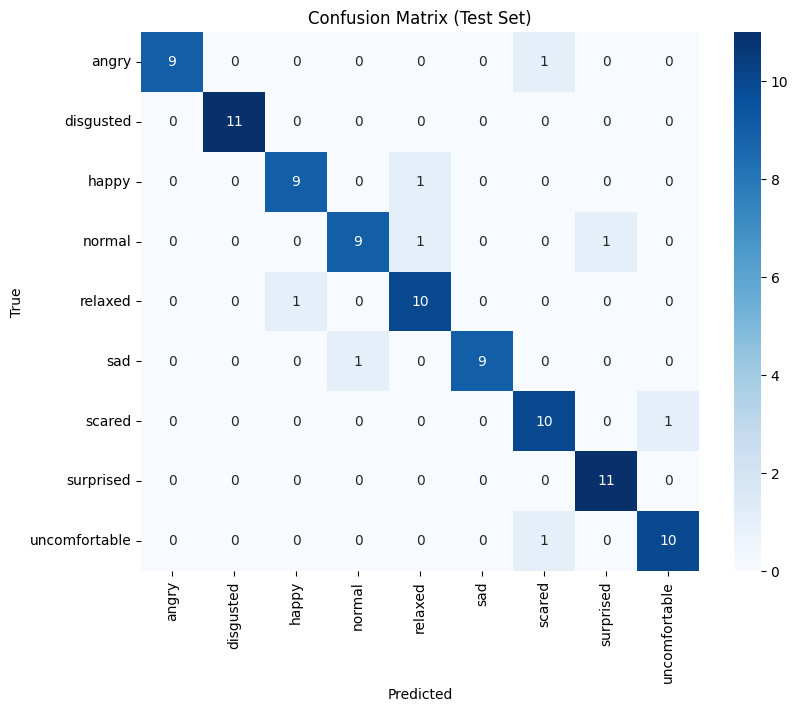

In [10]:
print("\nLoading best model for final evaluation...")
best_model_path = os.path.join(OUTPUT_DIR, "best_model")
best_model = RobertaForSequenceClassification.from_pretrained(best_model_path).to(device)
best_tokenizer = RobertaTokenizer.from_pretrained(best_model_path)
best_model.eval()


def evaluate_model(loader, model, device, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
           
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_trues, all_preds)
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss, all_trues, all_preds


class_weights_eval = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_eval = torch.tensor(class_weights_eval, dtype=torch.float).to(device)
criterion_eval = nn.CrossEntropyLoss(weight=class_weights_eval) 


print("\n--- Evaluating on Train Set ---")
train_acc, train_loss, _, _ = evaluate_model(train_loader, best_model, device, criterion_eval)

print("\n--- Evaluating on Validation Set ---")
val_acc, val_loss, _, _ = evaluate_model(val_loader, best_model, device, criterion_eval)

print("\n--- Evaluating on Test Set ---")
test_acc, test_loss, y_true, y_pred = evaluate_model(test_loader, best_model, device, criterion_eval)


print("\n" + "="*30)
print("📊 Final Model Comparison")
print("="*30)

comparison_data = {
    'Set': ['Train', 'Validation', 'Test'],
    'Accuracy': [train_acc, val_acc, test_acc],
    'Loss': [train_loss, val_loss, test_loss]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df['Accuracy'] = comparison_df['Accuracy'].map("{:.4f}".format)
comparison_df['Loss'] = comparison_df['Loss'].map("{:.4f}".format)
print(comparison_df.to_string(index=False))


print("\n" + "-"*30)
print("Overfitting & Generalization Check:")

train_val_gap = train_acc - val_acc
val_test_gap = val_acc - test_acc

print(f"Train/Validation Gap (Accuracy): {train_val_gap:.4f}")
print(f"Validation/Test Gap (Accuracy): {val_test_gap:.4f}")

if train_val_gap > 0.05: 
    print(" Warning: Possible overfitting (Train acc is much higher than Val acc)")
else:
    print(" Model generalizes well (Train ≈ Val)")
    
if abs(val_test_gap) > 0.02: 
    print(" Warning: Val/Test performance differs. (Sets might be different)")
else:
    print(" Val performance is consistent with Test performance.")

print("\n" + "="*30)
print("Detailed Test Set Report")
print("="*30)

print("\nTest Accuracy:", test_acc) 
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [11]:
!zip -r my_model_91_COMPLETE.zip /kaggle/working/roberta_best/best_model

  adding: kaggle/working/roberta_best/best_model/ (stored 0%)
  adding: kaggle/working/roberta_best/best_model/special_tokens_map.json (deflated 84%)
  adding: kaggle/working/roberta_best/best_model/merges.txt (deflated 53%)
  adding: kaggle/working/roberta_best/best_model/config.json (deflated 54%)
  adding: kaggle/working/roberta_best/best_model/vocab.json (deflated 68%)
  adding: kaggle/working/roberta_best/best_model/model.safetensors (deflated 34%)
  adding: kaggle/working/roberta_best/best_model/tokenizer_config.json (deflated 76%)
